In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('Hotel3.csv')

In [3]:
def clean_data(data):
    NaN_replacements = {"children": 0, "country": "Unknown", "agent": 0, "company": 0}
    data_clean = data.fillna(NaN_replacements)
    data_clean["meal"].replace("Undefined", "SC", inplace=True)
    zero_guests = list(
        data_clean[
            (data_clean["adults"] + data_clean["children"] + data_clean["babies"]) == 0
        ].index
    )
    data_clean.drop(data_clean.index[zero_guests], inplace=True)
    data_clean.to_csv("Hotel3.csv", index=False)
    return data_clean

In [4]:
print(data.head())
print(data.isnull().sum())
print(data.info())

          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1     

In [5]:
data = clean_data(data)

/tmp/ipykernel_449/3161885648.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


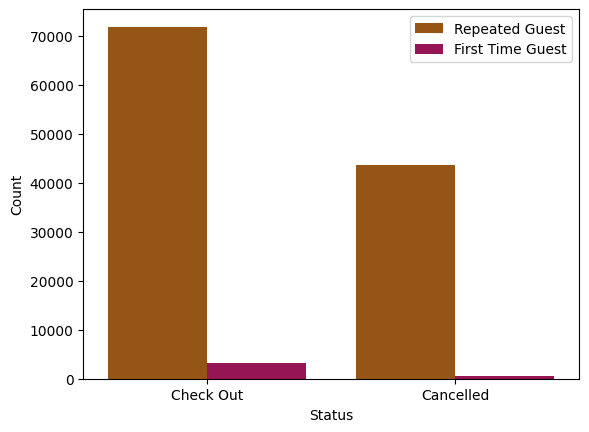

In [6]:
ax = sns.countplot(
    x="is_canceled",
    hue="is_repeated_guest",
    data=data,
    palette="brg_r",
    )
ax.set(xlabel="Status", ylabel="Count")
positions = (0, 1)
labels = ("Check Out", "Cancelled")
ax.set_xticklabels(labels)
legend_labels = ["Repeated Guest", "First Time Guest"]
ax.legend(labels=legend_labels)
plt.show()

/tmp/ipykernel_449/1242100754.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  order=pd.value_counts(data["arrival_date_month"]).index,
/tmp/ipykernel_449/1242100754.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


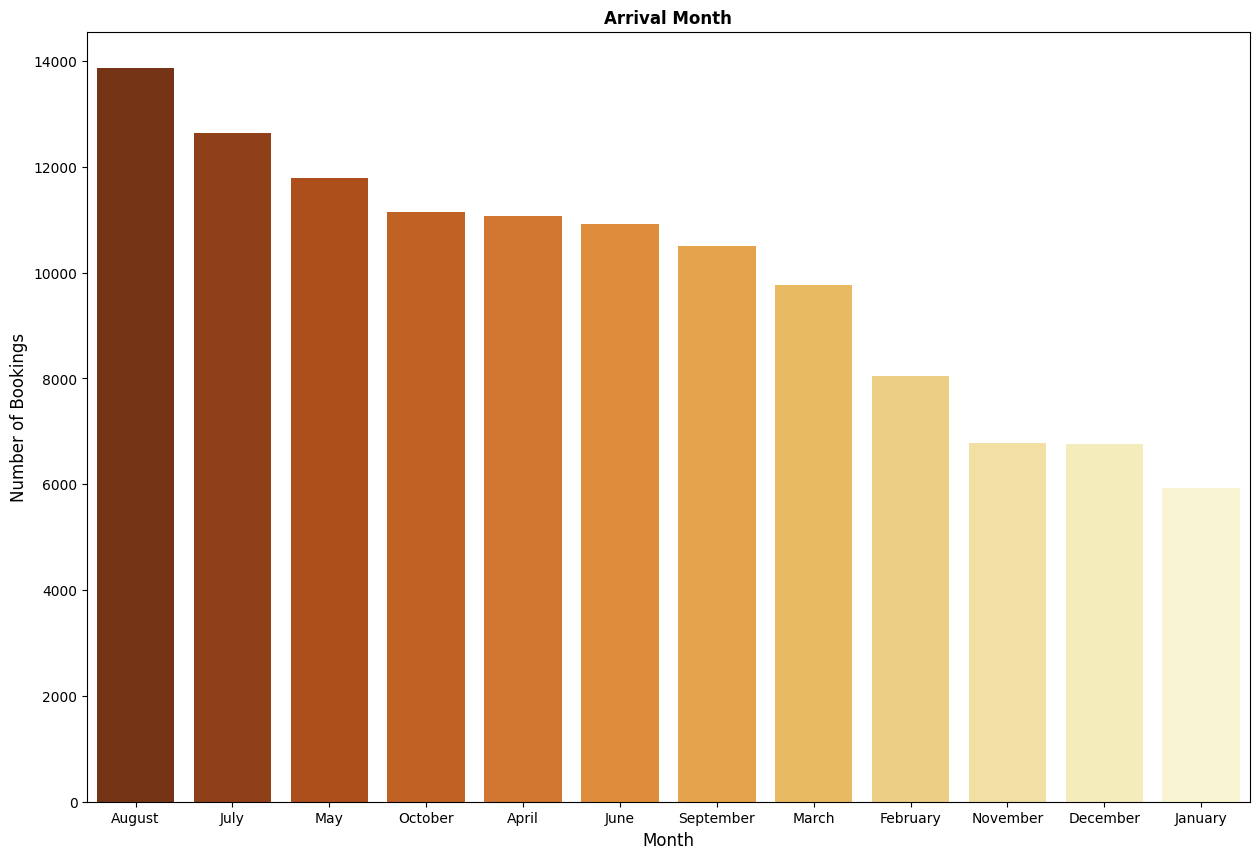

In [7]:
plt.figure(figsize=(15, 10))
sns.countplot(
    x="arrival_date_month",
    data=data,
    order=pd.value_counts(data["arrival_date_month"]).index,
    palette="YlOrBr_r",
    )
plt.title("Arrival Month", weight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Bookings", fontsize=12)
plt.show()

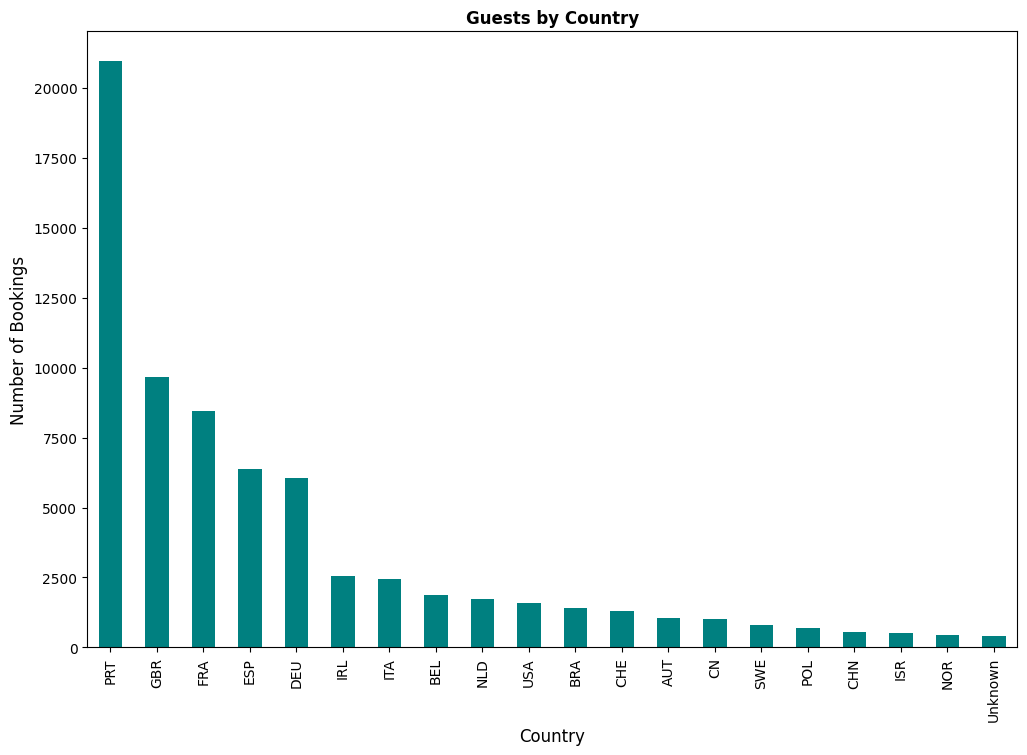

In [8]:
country_data = data[data["is_canceled"] == 0]["country"].value_counts()[:20]
plt.figure(figsize=(12, 8))
country_data.plot(kind="bar", color="teal")
plt.title("Guests by Country", weight="bold")
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number of Bookings", fontsize=12)
plt.show()

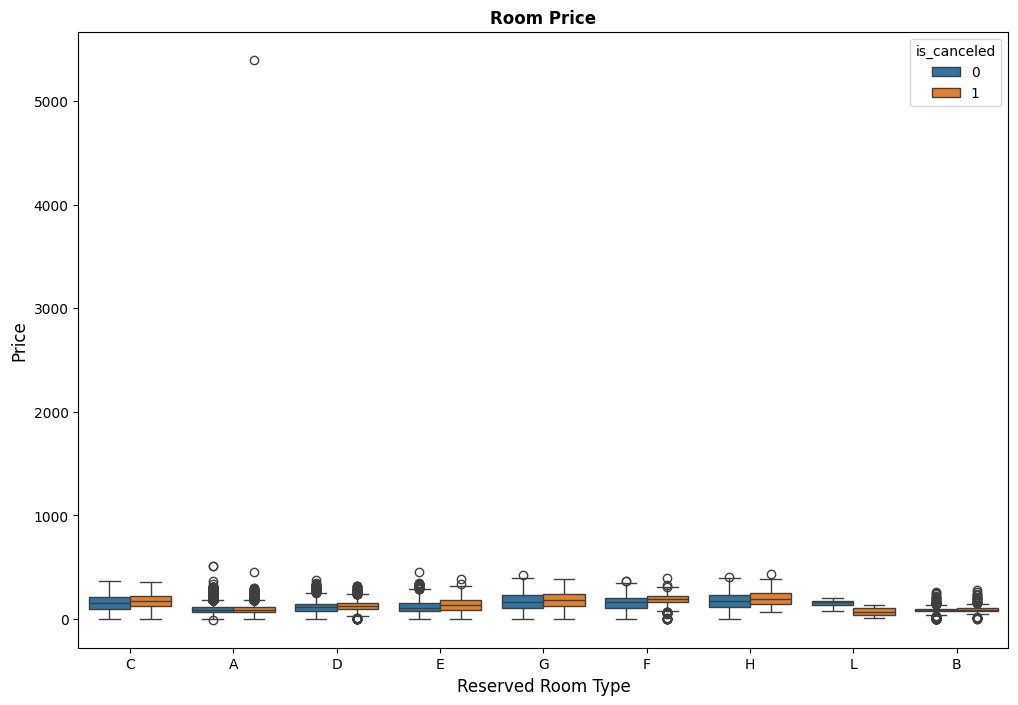

In [9]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="reserved_room_type", y="adr", hue="is_canceled", data=data)
plt.title("Room Price", weight="bold")
plt.xlabel("Reserved Room Type", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.show()

In [10]:
data = data[data['adr'] < 1000]

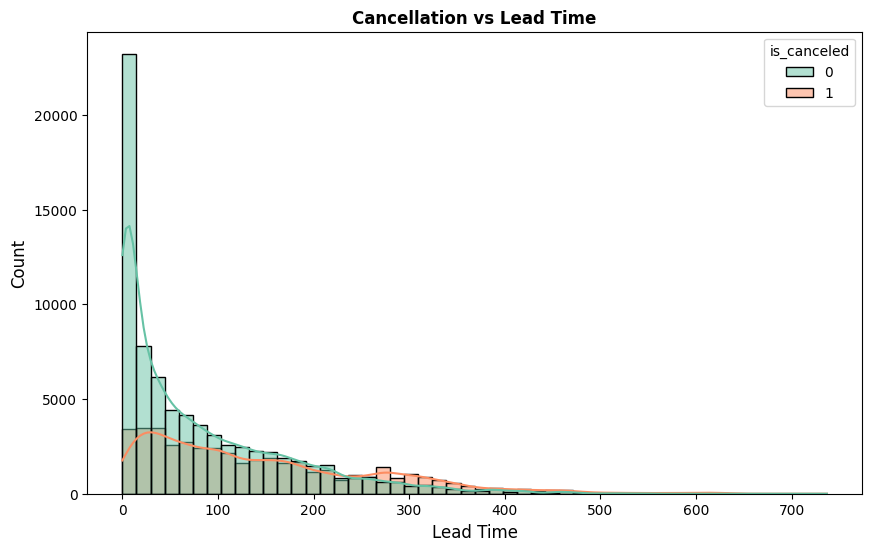

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(
        data=data,
        x="lead_time",
        hue="is_canceled",
        kde=True,
        bins=50,
        palette="Set2",
)
plt.title("Cancellation vs Lead Time", weight="bold")
plt.xlabel("Lead Time", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.show()

In [12]:
label_encoder = LabelEncoder()
data["hotel"] = label_encoder.fit_transform(data["hotel"])
data["arrival_date_month"] = label_encoder.fit_transform(data["arrival_date_month"])
data["meal"] = label_encoder.fit_transform(data["meal"])
data["country"] = label_encoder.fit_transform(data["country"])
data["market_segment"] = label_encoder.fit_transform(data["market_segment"])
data["distribution_channel"] = label_encoder.fit_transform(data["distribution_channel"])
data["reserved_room_type"] = label_encoder.fit_transform(data["reserved_room_type"])
data["assigned_room_type"] = label_encoder.fit_transform(data["assigned_room_type"])
data["deposit_type"] = label_encoder.fit_transform(data["deposit_type"])
data["customer_type"] = label_encoder.fit_transform(data["customer_type"])

In [13]:
X = data.drop("is_canceled", axis=1)
y = data["is_canceled"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
numeric_features = ["lead_time", "arrival_date_week_number", "arrival_date_day_of_month",
                        "stays_in_weekend_nights", "stays_in_week_nights", "adults", "children",
                        "babies", "previous_cancellations", "previous_bookings_not_canceled",
                        "booking_changes", "days_in_waiting_list", "required_car_parking_spaces",
                        "total_of_special_requests", "adr"]
categorical_features = ["hotel", "arrival_date_month", "meal", "country", "market_segment",
                            "distribution_channel", "reserved_room_type", "assigned_room_type",
                            "deposit_type", "customer_type"]

In [15]:
numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )
categorical_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
    )
preprocessor = ColumnTransformer(
        transformers=[("num", numeric_transformer, numeric_features),
                      ("cat", categorical_transformer, categorical_features)]
    )

In [16]:
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [17]:
def train_model(X_train, y_train):
    models = [
        ("Decision Tree", DecisionTreeClassifier()),
        ("Random Forest", RandomForestClassifier()),
        ("XGBoost", XGBClassifier()),
    ]
    results = []
    for name, model in models:
        model.fit(X_train, y_train)
        accuracy = cross_val_score(model, X_train, y_train, cv=5).mean()
        results.append((name, accuracy))
    results = sorted(results, key=lambda x: x[1], reverse=True)
    return results

In [18]:
def tune_hyperparameters(X_train, y_train):
    param_grid = {
        "Decision Tree": {"max_depth": [5, 10, None]},
        "Random Forest": {"n_estimators": [100, 200, 300], "max_depth": [5, 10, None]},
        "XGBoost": {"learning_rate": [0.1, 0.01, 0.001], "max_depth": [5, 10, None]}
    }
    models = [
        ("Decision Tree", DecisionTreeClassifier()),
        ("Random Forest", RandomForestClassifier()),
        ("XGBoost", XGBClassifier())
    ]
    best_models = []
    for name, model in models:
        grid_search = GridSearchCV(model, param_grid[name], cv=5)
        grid_search.fit(X_train, y_train)
        best_models.append((name, grid_search.best_estimator_))
    return best_models

In [19]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

In [21]:
best_models = tune_hyperparameters(X_train_preprocessed, y_train)
for name, model in best_models:
    accuracy, precision, recall, f1 = evaluate_model(model, X_test_preprocessed, y_test)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print()

Model: Decision Tree
Accuracy: 0.8437631071218857
Precision: 0.788953100689042
Recall: 0.795406162464986
F1-Score: 0.7921664899849356

Model: Random Forest
Accuracy: 0.8906551463803373
Precision: 0.887988209285188
Recall: 0.8100840336134454
F1-Score: 0.8472490771664616

Model: XGBoost
Accuracy: 0.8747168861672678
Precision: 0.8606656948493683
Recall: 0.7938375350140056
F1-Score: 0.8259019642128577



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d2fb35ab-bb88-4f2f-a948-c563569cbb7d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>